<div class='alert alert-success'>
    <h3 align="center"> Correllation, and cross-correlation of virtual sensors</h3>
</div>

Sample script to read history point.
    I am calculating the radial velocity, correlation and cross-correlation 

In [46]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [48]:
#Find the from data instead of manually providing
total_points = 800     #total points from the history point
probe_per_line = 40    #probe per line

probes_point = np.array([0, 80])
probes_point = probes_point.astype(int)

In [49]:
#filename and path to it
filename = "cyl_Ra07_4.his"
data_cordi = pd.read_table(filename, sep=r"\s+",  skiprows=1, nrows=total_points, header=None)
data_cordi = np.array(data_cordi)
first_point_probe = 0

In [50]:
# Here I am extracting the cordinates from the file itself
# from the exact same position as probes are
x_n = data_cordi[first_point_probe:first_point_probe+probe_per_line,0]
y_n = data_cordi[first_point_probe:first_point_probe+probe_per_line,1]
z_n = data_cordi[first_point_probe:first_point_probe+probe_per_line,2]

As it is tube radius, r = $\sqrt{(x^2+y^2)}$

In [51]:
norm_x = np.sqrt(x_n**2+y_n**2)

In [52]:
# BUT, we have probe point on diameter (instead of radius), so
# converting half of the point to negative 
norm_x = np.concatenate((np.negative(norm_x[:int(probe_per_line/2)]), norm_x[int(probe_per_line/2):]))

In [53]:
#%% Read from history point
# Read the data from file by skipping first 801 points

data = np.loadtxt(filename, skiprows = total_points+1, usecols = (0,1,2,3,4,5))
time_steps = int(data.shape[0]/total_points)

In [54]:
time_filtered_probe1 = np.zeros([probe_per_line,time_steps])



In [55]:
# Basically, I am filtering/rearranging all probes i.e. p0 to p19
# I am filtering U (v1) and V(v2)

v1_p0 = np.zeros([probe_per_line,time_steps])
v2_p0 = np.zeros([probe_per_line,time_steps])

v1_p1 = np.zeros([probe_per_line,time_steps])
v2_p1 = np.zeros([probe_per_line,time_steps])


for i in range (0, time_steps):
    time_filtered_probe1[:,i] = data[(probes_point[0]+i*total_points):
        (probes_point[0]+probe_per_line+i*total_points),0]
    
    v1_p0[:,i] = data[(probes_point[0]+i*total_points):
        (probes_point[0]++probe_per_line+i*total_points),1]
    v2_p0[:,i] = data[(probes_point[0]+i*total_points):
        (probes_point[0]++probe_per_line+i*total_points),2]

    v1_p1[:,i] = data[(probes_point[1]+i*total_points):
        (probes_point[1]++probe_per_line+i*total_points),1]
    v2_p1[:,i] = data[(probes_point[1]+i*total_points):
        (probes_point[1]++probe_per_line+i*total_points),2]


In [56]:
#%% Now we wil do averaging in two part        
# 1. First, I will average within the circle for each probe 
# For that, I find the idicies so that we are in circle of -.1 (12) to +.1 (27)
# So if we want to change radius of circle then we need to change indices

i1 = 12
i2 = 27

In [57]:
# Verifying if I did right
t = np.unique(time_filtered_probe1)
xt, tt = np.meshgrid(norm_x, t)
#tt= tt-tt[0]   #initialize time

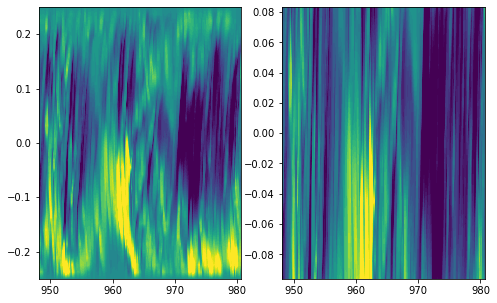

In [58]:
# we can notice same pattern in first and second figure for given Y AXIS
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(8, 5))
axs[0].contourf(tt, xt, v1_p0.T, vmin=-.3, vmax=.3, levels = 100)
axs[1].contourf(tt[:,i1:i2], xt[:,i1:i2], v1_p0[i1:i2,:].T, vmin=-.3, vmax=.3, levels = 100)
plt.show()

In [59]:
# Continuing
v1_p0_mean = np.mean(v1_p0[i1:i2,:],axis = 0)
v2_p0_mean = np.mean(v2_p0[i1:i2,:],axis = 0)

v1_p1_mean = np.mean(v1_p1[i1:i2,:],axis = 0)
v2_p1_mean = np.mean(v2_p1[i1:i2,:],axis = 0)

In [60]:
# 2. Now We will take mean for all probe within specifiied area
v1_mean = np.mean(np.array([v1_p0_mean, v1_p1_mean]), axis = 0)        
v2_mean = np.mean(np.array([v2_p0_mean, v2_p1_mean]), axis = 0)
theta_v12 = np.arctan(v2_mean/v1_mean)

In [61]:
time = t
angle = theta_v12
dt = np.mean(np.ediff1d(time))  # average time step
freq = np.fft.rfftfreq(time.size, dt)  # frequency array
fft = np.fft.rfft(angle)  # spectrum (complex values)
fft_ampl = np.abs(fft)  # spectrum amplitude
fft_phase = np.angle(fft)  # spectrum phase (in radian

$\phi$ is in radian units, see:  https://keisan.casio.com/exec/system/1359534107

In [62]:
def cart2pol(x, y, z):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    z = z
    return(rho, phi, z)

def pol2cart(rho, phi, z):   
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    z = z
    return(x, y, z)


In [63]:
# Converting all 800 points from Cartesian to Polar
# i.e. x,y,z -> r, theta, z
data_cordi_cyl = np.array(cart2pol(data_cordi[:,0], data_cordi[:,1], 
                                   data_cordi[:,2]) ).T

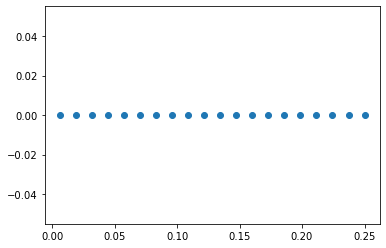

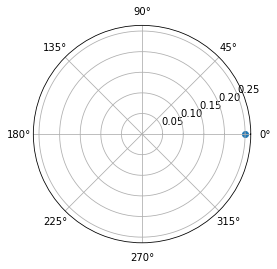

In [64]:
# VERIFY our conversion by drawing
plt.scatter(data_cordi[0:20,0],data_cordi[0:20,1])    
plt.show()  
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(data_cordi_cyl[0,1],data_cordi_cyl[0,0])
plt.show()

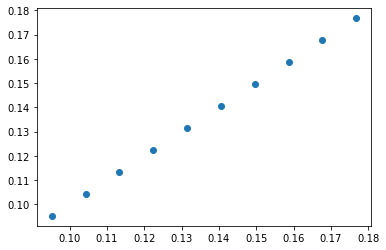

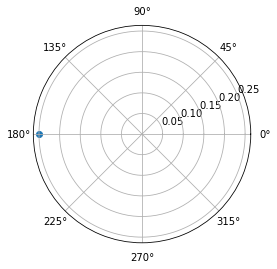

In [65]:
# VERIFY our conversion by drawing
plt.scatter(data_cordi[40:50,0],data_cordi[40:50,1])    
plt.show()  
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(data_cordi_cyl[39,1],data_cordi_cyl[39,0])
plt.show()

In [66]:
probe_rtz1 = 161 # .12, 0, .5
probe_rtz2 = 198 # .12, pi, .5

print("Here I am checking the probe position in two different coordinates")
print("-------------------------------------------------------------------")


print("Desired location1 = ",data_cordi[probe_rtz1])
print("Desired location1 = ",data_cordi_cyl[probe_rtz1])
print("Desired location2 = ",data_cordi[probe_rtz2])
print("Desired location2 = ",data_cordi_cyl[probe_rtz2])

Here I am checking the probe position in two different coordinates
-------------------------------------------------------------------
Desired location1 =  [0.2371795  0.         0.25113645]
Desired location1 =  [0.2371795  0.         0.25113645]
Desired location2 =  [-0.2371795   0.          0.25113645]
Desired location2 =  [0.2371795  3.14159265 0.25113645]


So conversion of x, y and z is correct "data_cordi_cyl" contain R, $\theta$ and Z. Now, will transform all velocity from Cartesian to polar
Initialize velocity. "cyl_velo" will contain $U_r, U_{\theta}, U_z$

In [67]:
cyl_velo = np.zeros([len(data[:,0]), 3])
velocity_theta = np.zeros([len(data[:,0])])

In [68]:
#Converting to Pandas so that I can see in table form
pd_cyl = pd.DataFrame(data_cordi_cyl)

# index 330 is corresponding to our desired location
probe_rtz = 320   #<----------------------------
print("Desired location = ",data_cordi_cyl[probe_rtz])

# Finding tempR at this location for all time steps
T_rtz = np.zeros([time_steps])

for i in range (0, time_steps):
    T_rtz[i] = data[(probe_rtz+i*total_points),5]

Desired location =  [0.25 0.   0.5 ]


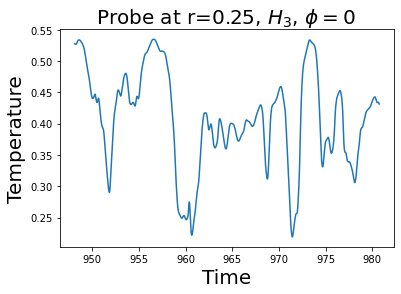

In [69]:
##Let's see the timeseries of temperature at this point
plt.plot(t, T_rtz)
plt.title('Probe at r=0.25, $H_3$, $\phi=0$ ', fontsize=20)
plt.xlabel("Time", fontsize=20)
plt.ylabel("Temperature", fontsize=20)
plt.show()

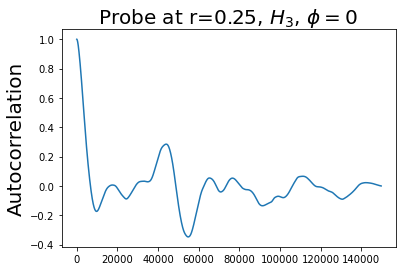

In [70]:
from statsmodels.tsa.stattools import acf
acf1 = acf(T_rtz,nlags=1500000,fft=False)
plt.plot(acf1)
plt.title('Probe at r=0.25, $H_3$, $\phi=0$ ', fontsize=20)
plt.xlabel("", fontsize=20)
plt.ylabel("Autocorrelation", fontsize=20)
plt.show()

### 2. Cross correlation in one plane

In [71]:
# set the index of each sensor
probe_rtz1 = 480 # .12, 0, .5   (plane H3)  
probe_rtz2 = 519 # .12, pi, .5  (plane H3)

In [72]:
print("Desired location1 = ",data_cordi_cyl[probe_rtz1])
print("Desired location2 = ",data_cordi_cyl[probe_rtz2])

Desired location1 =  [0.25       0.         0.74886358]
Desired location2 =  [0.25       3.14159265 0.74886358]


In [73]:
# Finding tempR at this location for all time steps
T_rtz1 = np.zeros([time_steps])
T_rtz2 = np.zeros([time_steps])

In [74]:
for i in range (0, time_steps):
    T_rtz1[i] = data[(probe_rtz1+i*total_points),5]
    T_rtz2[i] = data[(probe_rtz2+i*total_points),5]

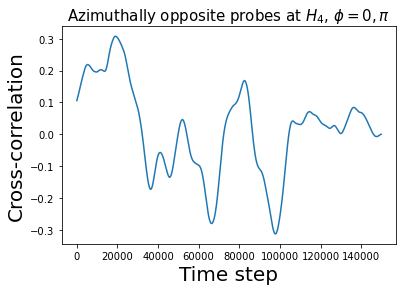

In [75]:
from statsmodels.tsa.stattools import ccf
ccf12 = ccf(T_rtz1, T_rtz2, unbiased=False)
plt.xlabel("Time step", fontsize=20)
plt.ylabel("Cross-correlation", fontsize=20)
plt.title('Azimuthally opposite probes at $H_4$, $\phi=0,\pi$', fontsize=15)
plt.plot(ccf12)
plt.show()

Correlation for two points at same distance and $\theta$ but at "two different planes"
index 170 and 490 is corresponding to our desired location

In [76]:
probe_rtz3 = 160 # .12, 0, .25 (plane H2)
probe_rtz4 = 320 # .12, pi, .75 (plane H4)

In [77]:
print("Desired location1 = ",data_cordi_cyl[probe_rtz3])
print("Desired location2 = ",data_cordi_cyl[probe_rtz4])

Desired location1 =  [0.25       0.         0.25113645]
Desired location2 =  [0.25 0.   0.5 ]


In [78]:
# Finding tempR at this location for all time steps
T_rtz3 = np.zeros([time_steps])
T_rtz4 = np.zeros([time_steps])

for i in range (0, time_steps):
    T_rtz3[i] = data[(probe_rtz3+i*total_points),5]
    T_rtz4[i] = data[(probe_rtz4+i*total_points),5]

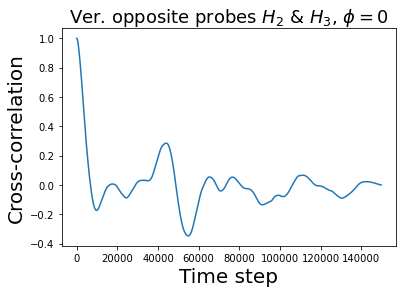

In [79]:
from statsmodels.tsa.stattools import ccf
ccf34 = ccf(T_rtz4, T_rtz4, unbiased=False)
plt.xlabel("Time step", fontsize=20)
plt.ylabel("Cross-correlation", fontsize=20)
plt.title('Ver. opposite probes $H_2$ & $H_3$, $\phi=0$', fontsize=18)
plt.plot(ccf34)
plt.show()

 Correlation for $"u_z"$ mid plane on which points are oppositeindex 330 and 349 is corresponding to our desired location

In [80]:
probe_rtz1 = 321 # .12, 0, .5 (plane H3)
probe_rtz2 = 358 # .12, pi, .5 (plane H3)